# Projeto: Seleção e Otimização de Modelos para Manutenção Preditiva de Máquinas

### Equipe:
- Bruno Da Costa Prianti
- Daniel Modesto De Souza
- Dário Alef Barros Lima
- Karen Letícia Santana Da Silva
- Willian Do Nascimento Severiano

### Contexto do Projeto

A **manutenção preditiva** é um pilar da Indústria 4.0, permitindo a antecipação de falhas em equipamentos para reduzir custos e aumentar a eficiência. A aplicação de **Machine Learning (ML)** neste cenário possibilita a criação de modelos capazes de prever falhas com base em dados de telemetria, transformando a manutenção reativa em uma estratégia proativa.

Este projeto documenta o processo sistemático de desenvolvimento de uma solução para prever falhas em máquinas, partindo de um modelo **baseline** (Regressão Logística) e evoluindo para algoritmos mais avançados, como **ensembles** (Random Forest, AdaBoost) e **meta-modelos** (Voting Classifier). O objetivo é encontrar o equilíbrio ideal entre performance preditiva e complexidade do modelo.

### Sobre o Dataset
- **Origem**: Sintético, gerado com base em um modelo realista de processos de fresagem.
- **Tamanho**: 10.000 registros e 14 variáveis.
- **Referência**: S. Matzka, *Explainable Artificial Intelligence for Predictive Maintenance Applications*, AI4I 2020.

### Variáveis Principais
- **Variável Alvo (Target)**: `Machine Failure` (0 para "Sem Falha", 1 para "Falha").
- **Principais Preditores (Features)**:
    - `UID`: Identificador único da amostra.
    - `Product ID`: Código do produto.
    - `Type`: Categoria do produto (L, M, H = baixa, média, alta qualidade).
    - `Air Temperature [K]`: Temperatura do ar no ambiente (em Kelvin).
    - `Process Temperature [K]`: Temperatura do processo de usinagem (em Kelvin).
    - `Rotational Speed [rpm]`: Velocidade de rotação da ferramenta (em rotações por minuto).
    - `Torque [Nm]`: Torque aplicado pela ferramenta (em Newton-metros).
    - `Tool Wear [min]`: Tempo de desgaste da ferramenta (em minutos).

### Modos de Falha (Informativo)
> O dataset também contém variáveis que indicam o tipo específico da falha, embora não sejam o alvo principal da nossa previsão binária.
- **TWF**: Falha por Desgaste da Ferramenta (*Tool Wear Failure*).
- **HDF**: Falha por Dissipação de Calor (*Heat Dissipation Failure*).
- **PWF**: Falha por Perda de Potência (*Power Failure*).
- **OSF**: Falha por Sobrecarga (*Overstrain Failure*).
- **RNF**: Falha Aleatória (*Random Failure*).

### Objetivo deste Milestone (Milestone 5)

Este notebook cumpre os requisitos do quinto milestone do projeto. As etapas executadas aqui são:
1.  **Treinamento de Modelos Avançados**: Implementação de múltiplos algoritmos que superam o baseline, utilizando técnicas de **ensemble** como `Random Forest`, `AdaBoost`, `Gradient Boosting` e `VotingClassifier`.
2.  **Comparação de Desempenho**: Geração de uma **tabela comparativa** completa, avaliando todos os modelos com base nas métricas de F1-Score, Precisão e Recall.
3.  **Documentação e Justificativa**: Utilização de células Markdown para explicar cada linha de código, as técnicas empregadas e para **interpretar os resultados** de forma crítica.
4.  **Seleção do Modelo Final**: Análise da tabela de resultados para justificar a escolha do modelo campeão, considerando não apenas a performance (`Test F1-Score`), mas também o **custo-benefício** (`Complex Weight`).


# 0.versionamento de bibliotecas

In [20]:
# utilizamos o google colab para desenvolver o codigo do trabalho,
# intrução para rodar o notebook:
# desconmentar os pip install abaixo e rodar as celulas abaixo dessa celula

# !pip install matplotlib==3.10.6
# !pip install pandas==2.3.2
# !pip install scikit-learn==1.7.1
# !pip install optuna==4.5.0

# 1.import das bibliotecas

In [21]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import tarfile
import urllib.request

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# metodos proprios pra facilitar algumas etapas do trabalho
def precision_recall_f1(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    return {
        "precision": round(precision,5),
        "recall": round(recall, 5),
        "f1": round(f1, 5),
    }

def cv_metrics_precision_recall_f1(model, X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    f1_scorer = make_scorer(f1_score, pos_label=1)
    precision_scorer = make_scorer(precision_score, pos_label=1)
    recall_scorer = make_scorer(recall_score, pos_label=1)

    scores_f1 = cross_val_score(model, X, y.values.ravel(), cv=skf, scoring=f1_scorer)
    scores_precision = cross_val_score(model, X, y.values.ravel(), cv=skf, scoring=precision_scorer)
    scores_recall = cross_val_score(model, X, y.values.ravel(), cv=skf, scoring=recall_scorer)

    return {
        'precision': float(round(scores_precision.mean(), 5)),
        'recall': float(round(scores_recall.mean(), 5)),
        'f1': float(round(scores_f1.mean(), 5))
    }

class ModelingExperiment:
    def __init__(self):
        self.records = []

    def save(self, name, model=None, metrics=None, complex_weight=None):
        print("model saved ...", model)
        self.records.append({
            "Model": name,
            "Model Obj": model,
            "Complex Weight": complex_weight,
            "Model Params": str(model) if model else None,
            "Train Precision": metrics.get("train", {}).get("precision") if metrics else None,
            "Train Recall": metrics.get("train", {}).get("recall") if metrics else None,
            "Train F1": metrics.get("train", {}).get("f1") if metrics else None,
            "Validation Precision": metrics.get("train", {}).get("precision") if metrics else None,
            "Validation Recall": metrics.get("train", {}).get("recall") if metrics else None,
            "Validation F1": metrics.get("train", {}).get("f1") if metrics else None,
            "Test Precision": metrics.get("test", {}).get("precision") if metrics else None,
            "Test Recall": metrics.get("test", {}).get("recall") if metrics else None,
            "Test F1": metrics.get("test", {}).get("f1") if metrics else None
        })

    def summary(self, include_obj=False):
        df = pd.DataFrame(self.records)
        if not include_obj and "Model Obj" in df.columns:
            df = df.drop(columns=["Model Obj"])
        return df

**Legenda:**  
Nesta célula realizamos três etapas principais:

1. **Importação de bibliotecas:**  
   - `numpy`, `pandas`: manipulação de arrays e tabelas.  
   - `seaborn`, `matplotlib.pyplot`: criação de gráficos e visualizações.  
   - `pathlib.Path`, `tarfile`, `urllib.request`: operações com diretórios, arquivos compactados e downloads.  
   - `sklearn.model_selection` e `sklearn.metrics`: ferramentas para validação cruzada e cálculo de métricas de classificação.  

2. **Definição de funções auxiliares:**  
   - `precision_recall_f1`: recebe os valores verdadeiros e as probabilidades previstas, aplica um limiar de decisão (`threshold`) e retorna **precisão, recall e F1-score** em formato de dicionário.  
   - `cv_metrics_precision_recall_f1`: aplica **validação cruzada estratificada** em um modelo, calculando médias de precisão, recall e F1-score ao longo das divisões dos dados.  

3. **Criação da classe `ModelingExperiment`:**  
   - Armazena informações sobre cada modelo treinado, incluindo nome, parâmetros e métricas em treino, validação e teste.  
   - O método `save` adiciona um registro na lista interna `records`.  
   - O método `summary` organiza esses registros em um **DataFrame**, facilitando a comparação entre os modelos testados.  

 Em resumo, esta célula prepara o ambiente para os experimentos, fornecendo **ferramentas de avaliação de métricas** e uma **estrutura para registrar e comparar modelos**.


# 2.leitura da base de dados tratada milestone 3:

In [22]:
def load_data():
    base_path = Path("datasets/industrial")
    base_path.mkdir(parents=True, exist_ok=True)

    url_base = "https://raw.githubusercontent.com/bpriantti/av2_grupo_b_vespertino/main/"

    files = {
        "x_train": base_path / "x_train.csv",
        "x_test": base_path / "x_test.csv",
        "y_train": base_path / "y_train.csv",
        "y_test": base_path / "y_test.csv",
    }

    for name, path in files.items():
        if not path.is_file():
            urllib.request.urlretrieve(url_base + f"{name}.csv", path)

    x_train = pd.read_csv(files["x_train"])
    x_test = pd.read_csv(files["x_test"])
    y_train = pd.read_csv(files["y_train"])
    y_test = pd.read_csv(files["y_test"])

    return x_train, x_test, y_train, y_test

In [23]:
x_train, x_test, y_train, y_test = load_data()

In [24]:
print("")
print("x_train head():")
display(x_train.head())
print("y_train head():")
display(y_train.head())
print("x_test head():")
display(x_test.head())
print("y_test head():")
display(y_test.head())


x_train head():


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_ordinal
0,0.146812,0.194985,3.424127,-2.323904,-1.190591,1.0
1,-0.302583,-0.681839,1.444367,-1.572974,0.310316,1.0
2,-0.552246,0.329881,0.559558,-1.082367,1.357824,1.0
3,-0.801910,-0.681839,0.028673,-0.121176,-0.174352,2.0
4,1.345196,1.611391,-0.474562,0.729878,-0.721558,1.0


y_train head():


,Machine failure
0,0
1,0
2,0
3,0
4,0


x_test head():


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_ordinal
0,-0.751977,-0.209703,0.072913,-0.601771,1.514169,2.0
1,-1.401102,-0.951630,-0.811895,0.149159,-0.002373,1.0
2,0.246677,1.274152,-0.590693,0.309357,-1.440742,1.0
3,1.644793,1.476496,-0.452442,0.069060,-0.940440,1.0
4,-0.052919,-0.412047,1.936542,-1.402764,-1.597087,2.0


y_test head():


,Machine failure
0,0
1,0
2,0
3,0
4,0


**Legenda:**  

#### Função `load_data`
Esta célula define a função `load_data`, responsável por **carregar e organizar os dados do projeto**:
Aqui a função load_data é chamada e suas saídas são atribuídas às variáveis de treino e teste.

    1.`x_train`, `x_test`: atributos (features) normalizados já preparados.

    2. `y_train`, `y_test`.: rótulos (targets) binários indicando falha ou não da máquina.

Essa função inicializa efetivamente os dados que serão usados em todo o restante do notebook.

---

#### Carregamento dos dados
```python
x_train, x_test, y_train, y_test = load_data()


# 3.0 Treinamento dos modelos:

>Nesta etapa, vamos explorar diferentes algoritmos de **Machine Learning** para prever falhas em máquinas de usinagem.  
O foco é avaliar o desempenho na **classe 1 (falha)** utilizando métricas como **Precision, Recall e F1-Score**.

Modelos a serem testados:
1. **Logistic Regression** `(Baseline)`
2. **Support Vector Machine**  
3. **Decision Tree**  
4. **Random Forest**  
5. **AdaBoost**  
6. **Gradient Boosting**    


#### Atribuição de Peso de Complexidade para Cada Modelo:

1.  **Logistic Regression (peso 1):**
    * Modelo mais simples, linear, ótimo como baseline.

2.  **Decision Tree (peso 2):**
    * Já captura relações não lineares, mas isoladamente tende a *overfitting* (sobresjuste).

3.  **Support Vector Machine (peso 3):**
    * Bom em problemas com margens de separação claras, mas exige ajuste fino (*tuning*) do kernel e não escala bem em grandes volumes de dados.

4.  **Random Forest (peso 4):**
    * Mais robusto que uma única árvore de decisão, pois é um conjunto (*ensemble*) delas. Reduz o *overfitting* e generaliza melhor.

5.  **AdaBoost (peso 5):**
    * Constrói um *ensemble* de forma sequencial, onde cada novo modelo foca em corrigir os erros do modelo anterior. É eficaz em dados com pouco ruído, mas pode ser sensível a *outliers* (valores atípicos).

6.  **Gradient Boosting (peso 6):**
    * Semelhante ao AdaBoost, também constrói modelos sequencialmente. No entanto, é mais flexível e poderoso, pois otimiza os erros residuais a cada passo usando um método de gradiente. Geralmente, apresenta um desempenho superior aos anteriores.

7.  **Voting Classifier (peso 7):**
    * É um meta-modelo que combina as previsões de vários modelos diferentes (por exemplo, Regressão Logística, SVM e Random Forest). A previsão final é decidida pela "votação" da maioria dos modelos (*hard voting*) ou pela média das probabilidades previstas por eles (*soft voting*). Sua principal vantagem é aumentar a robustez e a precisão ao agregar as "opiniões" de diferentes algoritmos, compensando as fraquezas individuais de cada um.

In [25]:
experimento = ModelingExperiment()

## 3.1 logistic regression:

In [ ]:
# from sklearn.linear_model import LogisticRegression

# log_reg = LogisticRegression(class_weight={0:1, 1:2}, random_state=42)
# log_reg.fit(x_train, y_train.values.ravel())

# y_train_probs = log_reg.predict_proba(x_train)[:, 1]
# y_test_probs = log_reg.predict_proba(x_test)[:, 1]

# metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
# metrics_val = cv_metrics_precision_recall_f1(log_reg, x_train, y_train, n_splits=5, random_state=42)
# metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)

# metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
# display(metrics)

{'train': {'precision': 0.58042, 'recall': 0.31439, 'f1': 0.40786},
 'val': {'precision': 0.56741, 'recall': 0.3029, 'f1': 0.39385},
 'test': {'precision': 0.69444, 'recall': 0.37879, 'f1': 0.4902}}

**Legenda:**

Nesta célula estamos treinando um modelo de **Regressão Logística** usando a biblioteca *scikit-learn*. Algumas observações importantes:

### Configuração do modelo
- `class_weight={0:1, 1:2}`: estamos dizendo ao modelo para dar o **dobro de peso à classe 1** em relação à classe 0.  
  Isso é útil quando há **desbalanceamento de classes**, pois força o algoritmo a prestar mais atenção à classe minoritária.  
- `random_state=42`: garante **reprodutibilidade**, ou seja, os mesmos resultados em execuções diferentes.  

---

### Treinamento (`fit`)
- O modelo aprende padrões nos dados de treino (`x_train`, `y_train`).  

---

### Probabilidades previstas (`predict_proba`)
- Calculamos a probabilidade de cada instância pertencer à classe **1**, tanto no treino quanto no teste.  
- Depois, avaliamos o modelo usando a função `evaluate_model`, com um **limiar (threshold) de 0.5**.  

---

### Métricas obtidas
**Treino:**
- **Precisão ≈ 0.58** → quando o modelo prevê a classe positiva, ele acerta em ~58% dos casos.  
- **Recall ≈ 0.31** → o modelo consegue recuperar apenas ~31% dos positivos reais (**sensibilidade baixa**).  
- **F1-score ≈ 0.40** → equilíbrio baixo, indicando que o modelo não está performando tão bem no treino.  

**Teste:**
- **Precisão ≈ 0.69** → acerta mais quando prevê positivo (~69%).  
- **Recall ≈ 0.37** → ainda captura poucos positivos (~37%).  
- **F1-score ≈ 0.49** → melhora em relação ao treino, mas ainda mostra que o modelo não está capturando bem os positivos.  

---

### Interpretação geral
- O modelo tem uma **precisão razoável**, mas um **recall baixo**.  
- Isso significa que ele **erra ao deixar escapar muitos casos positivos** (alta taxa de **falsos negativos**).  
- Como consequência, o **F1-score** fica moderado (~0.49), sugerindo que o modelo ainda **não está bem ajustado** e pode precisar de:  
  - Ajuste do **limiar de decisão**.  
  - Melhor balanceamento de classes.  
  - Testar outros modelos ou adicionar novas features.  


In [ ]:
# experimento.save(name="Logistic Regression", model=log_reg, metrics=metrics, complex_weight=1)

model saved ... LogisticRegression(class_weight={0: 1, 1: 2}, random_state=42)


**Legenda:**

> Nesta célula, o código utiliza o método `save` do objeto `experimento` para armazenar o modelo treinado e suas informações principais:
>
> -   `name="Logistic Regression"` → Identifica o modelo salvo com o nome "Logistic Regression".
> -   `model=log_reg` → Refere-se ao modelo de Regressão Logística que já foi treinado e agora será registrado.
> -   `metrics=metrics` → Inclui as métricas de avaliação calculadas (ex.: acurácia, F1-score, recall etc.) junto ao modelo.
> -   `complex_weight=1` → Define um peso de complexidade para o modelo, usado em comparações ou análises de custo/benefício.

**Em resumo**, essa linha registra o modelo e suas métricas dentro do sistema de experimentos, permitindo organização e reprodutibilidade.

## 3.2 SVM classifier:

### 3.2.1 fine tunning parameter config SVM:

In [28]:
# # comentamos pois ja encontramos os parametros - tempo de execucao aproximadamente: 41 minutos

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.svm import SVC
# import optuna

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scorer = make_scorer(f1_score, pos_label=1)

# def objective(trial):
#     C = trial.suggest_float("C", 0.1, 100, log=True)
#     weight_1 = trial.suggest_int("weight_1", 1, 10)

#     svm_model = SVC(
#         C=C,
#         class_weight={0:1, 1:weight_1},
#         probability=True,
#         random_state=42,
#     )

#     scores = cross_val_score(svm_model, x_train, y_train.values.ravel(), cv=skf, scoring=f1_scorer)
#     return scores.mean()

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)
# print("Melhores parâmetros:", study.best_trial.params)
# print("Melhor F1 médio na validação:", study.best_trial.value)

**Legenda:**

Nesta célula foi realizada a **otimização de hiperparâmetros da SVM** utilizando a biblioteca **Optuna**, com o objetivo de encontrar uma configuração de parâmetros que maximize o desempenho do modelo em termos de **F1-score**.  

---

### Parâmetros otimizados
- **`C` (regularização):** controla o equilíbrio entre **margem larga** e **classificação correta dos exemplos de treino**.  
  - Valores menores de `C` → permitem maior margem, mas aceitam mais erros no treino (modelo mais simples, com maior viés).  
  - Valores maiores de `C` → buscam classificar todos os exemplos corretamente, mesmo reduzindo a margem (modelo mais complexo, com risco de overfitting).  

- **`class_weight` (peso das classes):** aqui ajustamos o peso da **classe positiva (1)**.  
  - Isso é importante porque, em problemas de **desbalanceamento de classes**, o modelo tende a favorecer a classe majoritária.  
  - Ajustando o peso da classe 1, forçamos a SVM a dar **mais atenção às instâncias positivas**, ajudando a melhorar o **recall** e, consequentemente, o **F1-score**.  

---

### Estratégia de validação
- Foi utilizada **validação cruzada estratificada (5 folds)** para garantir que cada divisão tivesse a mesma proporção de classes, evitando viés nos resultados.  
- O critério de avaliação foi o **F1-score**, métrica que equilibra precisão e recall, escolhida porque o dataset provavelmente apresenta **desbalanceamento** entre classes.  

---

### Processo de otimização
- A função `objective(trial)` define como cada experimento de treinamento deve ser avaliado, recebendo diferentes combinações de `C` e `weight_1`.  
- O Optuna testou até **1000 combinações** desses hiperparâmetros.  
- Ao final, o estudo retornou:  
  - **Melhores parâmetros encontrados** (valores de `C` e `class_weight`).  
  - **Melhor valor médio de F1-score na validação cruzada**.  

---

### Justificativa
Optamos por realizar esta otimização porque a SVM é **sensível à escolha dos hiperparâmetros**, especialmente:  
- O valor de `C`, que influencia diretamente a complexidade do modelo.  
- O peso das classes, que pode corrigir o impacto do desbalanceamento.  

Dessa forma, garantimos que o modelo utilizado nas próximas etapas **não seja apenas uma configuração arbitrária**, mas sim o resultado de um processo sistemático de busca, visando **equilíbrio entre precisão e recall**.


### 3.2.2 fit best parameter config SVM:

In [ ]:
# from sklearn.svm import SVC

# svm_model = SVC(
#         C=99.90622647684818,
#         class_weight={0:1, 1:1},
#         probability=True,
#         random_state=42,
#     )


# svm_model.fit(x_train, y_train.values.ravel())

# y_train_probs = svm_model.predict_proba(x_train)[:, 1]
# y_test_probs = svm_model.predict_proba(x_test)[:, 1]

# metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
# metrics_val = cv_metrics_precision_recall_f1(svm_model, x_train, y_train, n_splits=5, random_state=42)
# metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
# metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
# display(metrics)

{'train': {'precision': 0.97525, 'recall': 0.74621, 'f1': 0.84549},
 'val': {'precision': 0.82832, 'recall': 0.66676, 'f1': 0.73733},
 'test': {'precision': 0.84091, 'recall': 0.56061, 'f1': 0.67273}}

**Legenda:**

Nesta célula estamos treinando um modelo de **SVM (Support Vector Machine)** usando a classe `SVC` da biblioteca *scikit-learn*. Algumas observações importantes:

---

### Configuração do modelo
- `C=99.9062`: parâmetro de **regularização** que controla a margem da SVM.  
- `class_weight={0:1, 1:1}`: indica que **não foi aplicado balanceamento de classes** (ambas têm o mesmo peso).  
- `probability=True`: habilita a saída de **probabilidades** via `predict_proba`.  
- `random_state=42`: garante **reprodutibilidade** dos resultados.  

---

### Treinamento (`fit`)
- O modelo é treinado com os dados de entrada (`x_train`) e os rótulos (`y_train`).  
- A SVM busca encontrar um **hiperplano ótimo** que separe as classes no espaço das features.  

---

### Probabilidades previstas (`predict_proba`)
- Após o treinamento, calculamos as **probabilidades da classe positiva (1)** para:  
  - **Treino:** `y_train_probs`  
  - **Teste:** `y_test_probs`  
- Essas probabilidades são avaliadas com um **limiar (threshold) = 0.5**, transformando-as em previsões binárias.  

---

### Métricas obtidas
**Treino:**  
- **Precisão ≈ 0.98** → quando o modelo prevê positivo, acerta quase sempre.  
- **Recall ≈ 0.75** → captura cerca de 75% dos casos positivos.  
- **F1-score ≈ 0.85** → bom equilíbrio entre precisão e recall no treino.  

**Validação cruzada (5 folds):**  
- **Precisão ≈ 0.83** → boa taxa de acerto nas previsões positivas.  
- **Recall ≈ 0.67** → captura 67% dos positivos, um pouco menor que no treino.  
- **F1-score ≈ 0.74** → desempenho consistente, indicando que o modelo generaliza razoavelmente bem.  

**Teste:**  
- **Precisão ≈ 0.84** → mantém boa taxa de acertos ao prever positivos.  
- **Recall ≈ 0.56** → consegue capturar pouco mais da metade dos casos positivos.  
- **F1-score ≈ 0.67** → equilíbrio moderado, inferior ao treino, mas dentro do esperado.  

---

### Interpretação geral
- O modelo de **SVM apresenta excelente precisão**, ou seja, quase nunca erra ao prever a classe positiva.  
- Porém, o **recall é mais baixo**, especialmente no teste (~0.56), mostrando que o modelo **deixa escapar muitos casos positivos** (falsos negativos).  
- O **F1-score de ~0.67 no teste** indica desempenho aceitável, mas há espaço para melhoria.  

Caminhos para evolução:  
- **Ajustar o parâmetro `C`** para encontrar melhor equilíbrio entre precisão e recall.  
- Testar **balanceamento de classes** (`class_weight="balanced"`) para melhorar o recall.  
- Avaliar outros kernels da SVM (linear, polinomial, RBF) para ver se melhoram a separação das classes.  


foi treinado o melhor modelo com os melhores parametros obtidos na otimizacao, fala um pouco das metricas resumidamente

In [ ]:
# experimento.save(name="Support Vector Classifier", model=svm_model, metrics=metrics, complex_weight=3)

model saved ... SVC(C=99.90622647684818, class_weight={0: 1, 1: 1}, probability=True,
    random_state=42)


> Nesta célula, o método `save` do objeto `experimento` é usado para armazenar o modelo de classificação SVM (Support Vector Classifier) junto às suas métricas de desempenho. Os parâmetros têm os seguintes papéis:

## 3.3 decision tree classifier:

### 3.3.1 fine tunning decision tree:

In [31]:
# # comentamos pois ja encontramos os parametros - tempo de execucao aproximadamente: 19 minutos

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.tree import DecisionTreeClassifier
# import optuna

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scorer = make_scorer(f1_score, pos_label=1)

# def objective(trial):
#     max_depth = trial.suggest_categorical("max_depth", [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
#     min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [2, 3, 5, 7, 9])
#     min_samples_split = trial.suggest_categorical("min_samples_split", [2, 3, 5, 7, 9])
#     min_impurity_decrease = trial.suggest_categorical("min_impurity_decrease", [0.0, 0.01, 0.001, 0.0001])
#     weight_1 = trial.suggest_int("weight_1", 1, 10)

#     tree = DecisionTreeClassifier(
#                                     max_depth=max_depth,
#                                     min_samples_leaf=min_samples_leaf,
#                                     min_samples_split=min_samples_split,
#                                     min_impurity_decrease=min_impurity_decrease,
#                                     class_weight={0: 1, 1: weight_1},
#                                     random_state=42
#                                 )

#     scores = cross_val_score(tree, x_train, y_train.values.ravel(), cv=skf, scoring=f1_scorer)
#     return scores.mean()

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

# print("Melhores parâmetros:", study.best_trial.params)
# print("Melhor F1 médio na validação:", study.best_trial.value)

**Legenda:**

Nesta célula foi realizada a **otimização dos hiperparâmetros de uma Árvore de Decisão** utilizando a biblioteca **Optuna**, com foco em maximizar o **F1-score**.  

---

### Parâmetros otimizados
- **`max_depth`**: profundidade máxima da árvore. Controla a complexidade; valores muito altos podem levar a overfitting.  
- **`min_samples_leaf`**: número mínimo de amostras em cada folha; evita folhas com poucos exemplos.  
- **`min_samples_split`**: número mínimo de amostras necessárias para realizar uma divisão; controla a fragmentação da árvore.  
- **`min_impurity_decrease`**: limite mínimo de redução de impureza para permitir uma divisão; ajuda a podar splits irrelevantes.  
- **`class_weight`**: ajusta o peso da classe positiva (1). Essencial em datasets desbalanceados, pois aumenta a importância das falhas (classe minoritária).  

---

### Estratégia de validação
- Utilizou-se **validação cruzada estratificada (5 folds)** para manter as proporções de classes em cada divisão.  
- A métrica usada foi o **F1-score**, ideal em cenários onde há **desbalanceamento de classes**, pois equilibra precisão e recall.  

---

### Justificativa
Optamos por otimizar porque árvores de decisão são altamente sensíveis à escolha de hiperparâmetros.  
Sem esse ajuste, o modelo poderia ficar **muito simples (alto viés)** ou **muito complexo (alto overfitting)**.  

Assim, a otimização garantiu um modelo melhor balanceado, capaz de capturar falhas sem comprometer demais a precisão.  


### 3.3.2 fit best parameter config decision tree:

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# tree_model = DecisionTreeClassifier(
#                                 max_depth=11,
#                                 min_samples_leaf=5,
#                                 min_samples_split=2,
#                                 min_impurity_decrease=0.0001,
#                                 class_weight={0: 1, 1: 1},
#                                 random_state=42
#                             )

# tree_model.fit(x_train, y_train.values.ravel())

# y_train_probs = tree_model.predict_proba(x_train)[:, 1]
# y_test_probs = tree_model.predict_proba(x_test)[:, 1]

# metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
# metrics_val = cv_metrics_precision_recall_f1(tree_model, x_train, y_train, n_splits=5, random_state=42)
# metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
# metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
# display(metrics)

{'train': {'precision': 0.86585, 'recall': 0.80682, 'f1': 0.83529},
 'val': {'precision': 0.8398, 'recall': 0.62104, 'f1': 0.71341},
 'test': {'precision': 0.79688, 'recall': 0.77273, 'f1': 0.78462}}

**Legenda:**

Nesta célula treinamos uma **Árvore de Decisão** já configurada com os melhores parâmetros encontrados na otimização anterior.  

### Configuração do modelo
- `max_depth=11`: profundidade máxima da árvore, evitando overfitting excessivo.  
- `min_samples_leaf=5`: cada folha deve ter pelo menos 5 amostras, aumentando a robustez.  
- `min_samples_split=2`: divisão mínima permitida de nós.  
- `min_impurity_decrease=0.0001`: só permite splits que tragam ganho mínimo de pureza.  
- `class_weight={0:1, 1:1}`: não aplicamos pesos diferenciados nesta versão final.  
- `random_state=42`: garante reprodutibilidade.  

---

### Treinamento e avaliação
- O modelo foi treinado em `x_train, y_train`.  
- As probabilidades previstas foram avaliadas tanto no **treino**, **validação cruzada** e **teste**.  
- Utilizamos `precision_recall_f1` e `cv_metrics_precision_recall_f1` para calcular as métricas principais.  

---

### Métricas obtidas
**Treino:**  
- Precisão ≈ **0.87**  
- Recall ≈ **0.81**  
- F1 ≈ **0.84**  

**Validação cruzada (5 folds):**  
- Precisão ≈ **0.84**  
- Recall ≈ **0.62**  
- F1 ≈ **0.71**  

**Teste:**  
- Precisão ≈ **0.80**  
- Recall ≈ **0.77**  
- F1 ≈ **0.78**  

---

### Interpretação geral
- O modelo apresenta **bom equilíbrio entre precisão e recall**, especialmente no teste, com **F1 ≈ 0.78**.  
- A precisão está alta (~0.80), o que significa poucas previsões falsas de falha.  
- O recall também é consistente (~0.77), mostrando que o modelo recupera a maior parte das falhas reais.  
- Comparado a modelos anteriores, a Árvore de Decisão mostra-se **mais equilibrada** e com **melhor recall**, o que é positivo em um problema de predição de falhas.  

In [ ]:
# experimento.save(name="Decision Tree Classifier", model=tree_model, metrics=metrics, complex_weight=2)

model saved ... DecisionTreeClassifier(class_weight={0: 1, 1: 1}, max_depth=11,
                       min_impurity_decrease=0.0001, min_samples_leaf=5,
                       random_state=42)


**Legenda:**

> Esta linha de código utiliza o método `save` do objeto `experimento` para registrar o modelo de Árvore de Decisão (`Decision Tree`) que foi treinado.
>**Em resumo**, o código salva o modelo de Árvore de Decisão, seu nome, suas métricas de performance e seu peso de complexidade no sistema de experimentação.


## 3.4 random forrest:

##### 3.4.1 fine tunning random forrest:

In [ ]:
# cometamos pois ja encontramos os parametros, descomentar caso queria rodar novamente - tempo de execucao aproximadamente: 325 minutos

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import optuna

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, pos_label=1)

def objective(trial):
    max_depth = trial.suggest_categorical("max_depth", [5, 10, 15, 20, 30, 40, 50])
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [2, 3, 4, 5])
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 3, 4, 5])
    weight_1 = trial.suggest_categorical("weight_1", [1, 2, 3, 4, 5, 6, 7, 8, 9,10])
    min_impurity_decrease = trial.suggest_categorical("min_impurity_decrease", [0.0, 0.01, 0.001, 0.0001])
    max_features = trial.suggest_categorical("max_features", [0.5, 0.7, 1.0, "sqrt", "log2"])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators = trial.suggest_categorical("n_estimators", [10, 50, 100, 200, 300, 500])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])


    rf_model = RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            class_weight={0:1, 1:weight_1},
            min_impurity_decrease=min_impurity_decrease,
            max_features=max_features,
            criterion=criterion,
            bootstrap=bootstrap,
            random_state=42
        )

    scores = cross_val_score(rf_model, x_train, y_train.values.ravel(), cv=skf, scoring=f1_scorer)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

print("Melhores parâmetros:", study.best_trial.params)
print("Melhor F1 médio na validação:", study.best_trial.value)

**Legenda:**

Nesta célula realizamos a **otimização de hiperparâmetros de uma Random Forest**, com o objetivo de maximizar o **F1-score**.  

---

### Parâmetros otimizados
- **`max_depth`**: profundidade máxima das árvores. Controla o equilíbrio entre simplicidade e complexidade do modelo.  
- **`min_samples_leaf`**: número mínimo de amostras em cada folha, evita divisões muito pequenas.  
- **`min_samples_split`**: número mínimo de amostras para que um nó seja dividido.  
- **`class_weight`**: ajusta o peso da classe positiva (1), essencial em datasets desbalanceados.  
- **`min_impurity_decrease`**: define a redução mínima de impureza para aceitar uma divisão.  
- **`max_features`**: número de variáveis consideradas em cada divisão (`0.5`, `0.7`, `1.0`, `"sqrt"`, `"log2"`). Controla a diversidade das árvores.  
- **`criterion`**: medida usada para avaliar divisões (impureza de **Gini** ou **Entropia**).  
- **`n_estimators`**: número de árvores no ensemble. Mais árvores aumentam estabilidade, mas também custo computacional.  
- **`bootstrap`**: se `True`, cada árvore é treinada em uma amostra bootstrap (com reposição), promovendo diversidade.  

---

### Estratégia de validação
- Utilizamos **validação cruzada estratificada (5 folds)** para manter a proporção das classes.  
- Métrica: **F1-score**, escolhida por equilibrar precisão e recall em um problema com **desbalanceamento de classes**.  

---

### Justificativa
A Random Forest possui diversos hiperparâmetros que impactam diretamente no desempenho.  
Optar por otimização sistemática evita escolhas arbitrárias e garante um modelo **mais robusto e equilibrado**.  

Com isso, conseguimos encontrar uma configuração de floresta que maximiza o **F1-score**, capturando mais falhas sem perder muita precisão.  

---

### 3.4.2 fit best parameter config Random Forrest:

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=15,
                                  n_estimators=500,
                                  min_samples_leaf=3,
                                  min_samples_split=3,
                                  class_weight={0:1, 1:7},
                                  min_impurity_decrease=0.0,
                                  max_features=0.7,
                                  criterion="entropy",
                                  bootstrap=True,
                                  random_state=42,
                                )

rf_model.fit(x_train, y_train.values.ravel())

y_train_probs = rf_model.predict_proba(x_train)[:, 1]
y_test_probs = rf_model.predict_proba(x_test)[:, 1]

metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
metrics_val = cv_metrics_precision_recall_f1(rf_model, x_train, y_train, n_splits=5, random_state=42)
metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
display(metrics)

{'train': {'precision': 0.94928, 'recall': 0.99242, 'f1': 0.97037},
 'val': {'precision': 0.8736, 'recall': 0.73091, 'f1': 0.79472},
 'test': {'precision': 0.9, 'recall': 0.81818, 'f1': 0.85714}}

**Legenda:**

Nesta célula treinamos o modelo **Random Forest** utilizando os parâmetros encontrados na otimização.  

### Configuração do modelo
- `max_depth=15`: controla a profundidade máxima das árvores, limitando complexidade.  
- `n_estimators=500`: usa 500 árvores, garantindo **alta estabilidade**.  
- `min_samples_leaf=3`: cada folha deve ter pelo menos 3 amostras.  
- `min_samples_split=3`: exige ao menos 3 amostras para dividir um nó.  
- `class_weight={0:1, 1:7}`: aumenta o peso da classe positiva, forçando o modelo a dar mais atenção às falhas.  
- `min_impurity_decrease=0.0`: sem exigência mínima de ganho de pureza.  
- `max_features=0.7`: cada árvore considera apenas 70% das variáveis em cada split, aumentando diversidade.  
- `criterion="entropy"`: usa entropia para medir qualidade das divisões.  
- `bootstrap=True`: usa amostras bootstrap para cada árvore.  
- `random_state=42`: garante reprodutibilidade.  

---

### Métricas obtidas
**Treino:**  
- Precisão ≈ **0.95**  
- Recall ≈ **0.99**  
- F1 ≈ **0.97**  

**Validação cruzada (5 folds):**  
- Precisão ≈ **0.87**  
- Recall ≈ **0.73**  
- F1 ≈ **0.79**  

**Teste:**  
- Precisão ≈ **0.90**  
- Recall ≈ **0.82**  
- F1 ≈ **0.86**  

---

### Interpretação geral
- O modelo apresenta **ótimo desempenho no treino (F1 ≈ 0.97)**, mas ainda generaliza bem para validação e teste.  
- **Teste com F1 ≈ 0.86**: forte equilíbrio entre precisão (90%) e recall (82%).  
- Comparado a modelos anteriores, a Random Forest consegue **capturar mais falhas** sem perder tanta precisão.  
- O recall elevado no teste indica que o modelo **consegue identificar a maior parte das falhas reais**, característica essencial para este tipo de problema.  

A Random Forest se mostra uma das abordagens mais promissoras até agora, com **bom trade-off entre recall e precisão** e baixa tendência a overfitting.

---

In [36]:
experimento.save(name="Random Forrest Classifier", model=rf_model, metrics=metrics, complex_weight=4)

model saved ... RandomForestClassifier(class_weight={0: 1, 1: 7}, criterion='entropy',
                       max_depth=15, max_features=0.7, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=500, random_state=42)


**Legenda:**

> Esta linha salva o modelo **Random Forest** treinado usando o método `save` do objeto `experimento`.


## 3.5 Ada boosting:

##### 3.5.1 fine tunning ada boosting:

In [37]:
# # comentamos pois ja encontramos os parametros, descomentar caso queria rodar novamente - tempo de execucao aproximadamente: 382 minutos

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# import optuna

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scorer = make_scorer(f1_score, pos_label=1)

# def objective(trial):
#     max_depth = trial.suggest_categorical("max_depth", [7, 17])
#     min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [3, 6])
#     min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.00153, 0.001532, log=True)
#     class_weight_1 = trial.suggest_categorical("class_weight_1", [2, 9])

#     n_estimators = trial.suggest_categorical("n_estimators", [377, 477])
#     learning_rate = trial.suggest_float("learning_rate", 0.05309, 0.0531, log=True)

#     base_tree = DecisionTreeClassifier(
#         max_depth=max_depth,
#         min_samples_leaf=min_samples_leaf,
#         min_impurity_decrease=min_impurity_decrease,
#         class_weight={0:1, 1:class_weight_1},
#         random_state=42
#     )

#     ada_model = AdaBoostClassifier(
#         estimator=base_tree,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         random_state=42
#     )

#     scores = cross_val_score(ada_model, x_train, y_train.values.ravel(), cv=skf, scoring=f1_scorer)
#     return scores.mean()

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

# print("Melhores parâmetros:", study.best_trial.params)
# print("Melhor F1 médio na validação:", study.best_trial.value)


**Legenda:**

Nesta célula realizamos a **otimização de hiperparâmetros do modelo AdaBoost** com um classificador base do tipo **Árvore de Decisão**, para maximizar o **F1-score**.  

---

### Parâmetros otimizados
- **Base Learner (Árvore de Decisão):**
  - `max_depth`: controla a profundidade máxima da árvore (7 ou 17 testados). Árvores mais profundas capturam mais padrões, mas podem superajustar.  
  - `min_samples_leaf`: número mínimo de amostras em cada folha.  
  - `min_impurity_decrease`: exige uma redução mínima na impureza para permitir uma divisão, ajudando a evitar divisões irrelevantes.  
  - `class_weight={0:1, 1:k}`: ajusta o peso da classe positiva (1), essencial para lidar com o **desbalanceamento**.  

- **AdaBoost:**
  - `n_estimators`: número de classificadores fracos combinados (377 ou 477 testados). Mais estimadores tendem a aumentar a estabilidade.  
  - `learning_rate`: taxa de aprendizado que controla a contribuição de cada classificador fraco. Valores pequenos (como ~0.053) tornam o modelo mais conservador e estável.  

---

### Estratégia de validação
- Foi aplicada **validação cruzada estratificada (5 folds)** para garantir que a proporção entre classes fosse preservada em cada divisão.  
- A métrica usada foi o **F1-score**, pois equilibra precisão e recall, ideal em problemas com classes desbalanceadas.  

---

### Justificativa
O AdaBoost combina vários **classificadores fracos (árvores pouco profundas)** para formar um modelo mais robusto.  
A escolha correta de hiperparâmetros é crucial, pois:  
- Árvores muito profundas ou com muitos estimadores podem levar a **overfitting**.  
- Árvores muito rasas ou poucos estimadores podem levar a **underfitting**.  

Assim, a otimização garantiu que o modelo fosse configurado de forma equilibrada, maximizando o F1-score sem perder generalização.  


### 3.5.2 fit best parameter config Adaboosting:

In [38]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier

# base_tree = DecisionTreeClassifier(
#         max_depth=17,
#         min_samples_leaf=3,
#         min_impurity_decrease=0.0015308770816931528,
#         class_weight={0:1, 1:9},
#         random_state=42
#     )

# ada_model = AdaBoostClassifier(
#     estimator=base_tree,
#     n_estimators=477,
#     learning_rate= 0.05309756471678731,
#     random_state=42
# )


# ada_model.fit(x_train, y_train.values.ravel())

# y_train_probs = ada_model.predict_proba(x_train)[:, 1]
# y_test_probs = ada_model.predict_proba(x_test)[:, 1]

# metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
# metrics_val = cv_metrics_precision_recall_f1(ada_model, x_train, y_train, n_splits=5, random_state=42)
# metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
# metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
# display(metrics)

**Legenda:**

Nesta célula foi treinado o modelo **AdaBoost** com base em uma **Árvore de Decisão** configurada com os melhores parâmetros obtidos na otimização.  

### Configuração do modelo
- **Base Learner (DecisionTreeClassifier):**
  - `max_depth=17`: árvore relativamente profunda, capturando interações complexas.  
  - `min_samples_leaf=3`: garante robustez mínima em cada folha.  
  - `min_impurity_decrease≈0.00153`: evita splits pouco relevantes.  
  - `class_weight={0:1, 1:9}`: dá muito mais peso às falhas (classe positiva).  

- **AdaBoostClassifier:**
  - `n_estimators=477`: utiliza 477 árvores fracas combinadas.  
  - `learning_rate≈0.053`: taxa de aprendizado baixa, evitando overajuste e dando peso equilibrado a cada árvore.  
  - `random_state=42`: reprodutibilidade.  

---

### Métricas obtidas
**Treino:**  
- Precisão = **1.00**  
- Recall = **1.00**  
- F1 = **1.00**  

**Validação cruzada (5 folds):**  
- Precisão ≈ **0.87**  
- Recall ≈ **0.73**  
- F1 ≈ **0.79**  

**Teste:**  
- Precisão ≈ **0.93**  
- Recall ≈ **0.80**  
- F1 ≈ **0.86**  

---

### Interpretação geral
- No **treino**, o modelo atingiu métricas perfeitas ``(overfitting evidente)``.  
- Porém, na **validação** e **teste**, as métricas são bem mais realistas, com **F1 ≈ 0.86 no teste**, mostrando excelente equilíbrio entre precisão e recall.  
- O modelo é capaz de **capturar a maioria das falhas (recall alto ≈ 0.80)**, ao mesmo tempo em que mantém **baixa taxa de falsos positivos (precisão ≈ 0.93)**.  

>Conclusão: O AdaBoost com Decision Trees demonstrou ser um **modelo extremamente competitivo**, equilibrando bem as métricas e se mostrando mais robusto que modelos anteriores.  

In [39]:
experimento.save(name="Ada Boosting Classifier", model=ada_model, metrics=metrics, complex_weight=5)

model saved ... AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 9},
                                                    max_depth=17,
                                                    min_impurity_decrease=0.0015308770816931528,
                                                    min_samples_leaf=3,
                                                    random_state=42),
                   learning_rate=0.05309756471678731, n_estimators=477,
                   random_state=42)


**Legenda:**

> Este comando utiliza o método `save` do objeto `experimento` para armazenar o modelo **AdaBoost** (Adaptive Boosting) treinado. **Em resumo**, a linha salva o modelo AdaBoost treinado, juntamente com seu nome, métricas de desempenho e peso de complexidade, no sistema de gerenciamento de experimentos.

## 3.6 Gradient Boosting:

##### 3.6.1 fine tunning Gradient Boosting:

In [40]:
# # Comentamos pois já encontramos os parametros, descomentar caso queria rodar novamente - tempo de execucao aproximadamente: 428 minutos

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import make_scorer, f1_score
# from sklearn.ensemble import GradientBoostingClassifier
# import optuna

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scorer = make_scorer(f1_score, pos_label=1)

# def objective(trial):
#     max_depth = trial.suggest_int("max_depth", 2, 21)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.01)
#     subsample = trial.suggest_float("subsample", 0.6, 1.0)
#     n_estimators = trial.suggest_int("n_estimators", 100, 500)
#     learning_rate = trial.suggest_float("learning_rate", 0.005, 0.2, log=True)
#     criterion = trial.suggest_categorical("criterion", ["squared_error", "friedman_mse"])
#     max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.7, 1.0])


#     g_boosting = GradientBoostingClassifier(
#         max_depth=max_depth,
#         min_samples_leaf=min_samples_leaf,
#         min_impurity_decrease=min_impurity_decrease,
#         subsample=subsample,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         criterion=criterion,
#         max_features=max_features,
#         random_state=42
#     )

#     scores = cross_val_score(g_boosting, x_train, y_train.values.ravel(), cv=skf, scoring=f1_scorer)
#     return scores.mean()

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

# print("Melhores parâmetros:", study.best_trial.params)
# print("Melhor F1 no teste:", study.best_trial.value)

**Legenda (Otimização – Gradient Boosting):**

Nesta célula foi realizada a **otimização de hiperparâmetros** para o modelo **Gradient Boosting**, com o objetivo de **maximizar o F1-score**.  

---

### Parâmetros otimizados
- **Estrutura das árvores:**
  - `max_depth`: profundidade máxima das árvores. Valores maiores capturam interações complexas, mas aumentam risco de overfitting.  
  - `min_samples_leaf`: número mínimo de amostras por folha, evitando folhas muito pequenas.  
  - `min_samples_split`: número mínimo de amostras necessário para uma divisão.  
  - `min_impurity_decrease`: garante que divisões só ocorram quando realmente relevantes.  

- **Gradient Boosting:**
  - `subsample`: proporção de dados usada em cada árvore. Valores < 1.0 tornam o modelo mais **estocástico**, aumentando a robustez.  
  - `n_estimators`: número de árvores combinadas.  
  - `learning_rate`: controla a contribuição de cada árvore. Valores baixos (como 0.05) reduzem overfitting.  
  - `criterion`: mede a qualidade das divisões (`friedman_mse` ou `squared_error`).  
  - `max_features`: número de features considerado em cada split.  

---

### Estratégia de validação
- **Validação cruzada estratificada (5 folds)** preservando a proporção de classes.  
- Métrica: **F1-score**, equilibrando precisão e recall para lidar com classes desbalanceadas.  

---

### Justificativa
O Gradient Boosting constrói **árvores sequenciais**, onde cada nova árvore corrige erros das anteriores.  
A otimização é essencial porque:
- Muitos estimadores e profundidade alta podem causar **overfitting**.  
- Poucos estimadores ou taxa de aprendizado muito alta podem levar a **underfitting**.  

A busca encontrou um equilíbrio entre **complexidade das árvores** e **taxa de aprendizado**, maximizando o desempenho.  

---

#### 3.6.2 fit best parameter config Gradient Boosting:

In [41]:
# from sklearn.ensemble import GradientBoostingClassifier

# g_boosting = GradientBoostingClassifier(
#                     max_depth=17,
#                     min_samples_leaf=8,
#                     min_impurity_decrease=0.0010266802349129212,
#                     subsample=0.866563526312947,
#                     n_estimators=265,
#                     learning_rate=0.04636051072855432,
#                     criterion='friedman_mse',
#                     max_features=1.0,
#                     random_state=42
#                 )

# g_boosting.fit(x_train, y_train.values.ravel())

# y_train_probs = g_boosting.predict_proba(x_train)[:, 1]
# y_test_probs = g_boosting.predict_proba(x_test)[:, 1]

# metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
# metrics_val = cv_metrics_precision_recall_f1(g_boosting, x_train, y_train, n_splits=5, random_state=42)
# metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
# metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
# display(metrics)

**Legenda (Modelo – Gradient Boosting):**

Aqui foi treinado o **GradientBoostingClassifier** com os melhores parâmetros encontrados pela otimização.  

---

### Configuração do modelo
- `max_depth=17`: árvores relativamente profundas, capturam relações complexas.  
- `min_samples_leaf=8`: garante folhas mais estáveis.  
- `min_impurity_decrease≈0.0010`: exige relevância mínima para splits.  
- `subsample≈0.87`: usa amostras parcialmente aleatórias, aumentando a generalização.  
- `n_estimators=265`: número moderado de árvores, suficiente para capturar padrões.  
- `learning_rate≈0.046`: taxa de aprendizado baixa, reduzindo risco de overfitting.  
- `criterion="friedman_mse"`: otimização padrão do scikit-learn para boosting.  
- `max_features=1.0`: utiliza todas as variáveis em cada split.  
- `random_state=42`: reprodutibilidade.  

---

### Métricas obtidas
**Treino:**  
- Precisão = **1.00**  
- Recall = **1.00**  
- F1 = **1.00**  

**Validação cruzada (5 folds):**  
- Precisão ≈ **0.89**  
- Recall ≈ **0.72**  
- F1 ≈ **0.80**  

**Teste:**  
- Precisão ≈ **0.88**  
- Recall ≈ **0.74**  
- F1 ≈ **0.80**  

---

### Interpretação geral
- No **treino**, o modelo atingiu métricas perfeitas ``(overfitting claro)``.  
- Já na **validação** e **teste**, o desempenho foi consistente (F1 ≈ 0.80), mostrando boa capacidade de generalização.  
- O modelo apresenta **alto equilíbrio** entre precisão e recall, sendo capaz de capturar falhas com boa cobertura sem exagerar nos falsos positivos.  

Conclusão: O Gradient Boosting mostrou-se **um dos modelos mais equilibrados**, combinando **alto recall** (captura a maioria dos casos positivos) com **boa precisão**, mantendo robustez em dados não vistos.

In [ ]:
# experimento.save(name="Gradient Boosting Classifier", model=g_boosting, metrics=metrics, complex_weight=6)

NameError: name 'g_boosting' is not defined

**Legenda:**

> Esta linha de código é responsável por salvar o modelo **Gradient Boosting** treinado no gerenciador de experimentos. **Em resumo**, o comando registra o modelo Gradient Boosting, seu nome, suas métricas e seu peso de complexidade para futuras análises e comparações.

# 4.0 comparando os modelos treinados individualmente:

In [ ]:
experimento.summary().drop(["Model Params"], axis=1)

,Model,Complex Weight,Train Precision,Train Recall,Train F1,Validation Precision,Validation Recall,Validation F1,Test Precision,Test Recall,Test F1
0,Logistic Regression,1,0.58042,0.31439,0.40786,0.58042,0.31439,0.40786,0.69444,0.37879,0.49020
1,Support Vector Classifier,3,0.97525,0.74621,0.84549,0.97525,0.74621,0.84549,0.84091,0.56061,0.67273
2,Decision Tree Classifier,2,0.86585,0.80682,0.83529,0.86585,0.80682,0.83529,0.79688,0.77273,0.78462
3,Random Forrest Classifier,4,0.94928,0.99242,0.97037,0.94928,0.99242,0.97037,0.90000,0.81818,0.85714
4,Ada Boosting Classifier,5,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.92982,0.80303,0.86179
5,Gradient Boosting Classifier,6,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.87500,0.74242,0.80328


**Legenda** (Tabela de Métricas)

> A tabela resultante é o placar final de desempenho para cada modelo, separada em três conjuntos de dados:
>
> -   **Métricas `Train`**: Desempenho do modelo nos dados que ele usou para treinar.
> -   **Métricas `Validation`**: Desempenho em dados de validação cruzada, usados para ajustar o modelo e evitar *overfitting*.
> -   **Métricas `Test`**: **As mais importantes**. Mostram como o modelo generaliza para dados completamente novos, que ele nunca viu antes.
>
> **Observação Importante**: Note que os modelos `Ada Boosting` e `Gradient Boosting` têm performance perfeita (1.00) nos dados de treino. Isso é um forte sinal de **overfitting**, onde o modelo "decorou" as respostas do treino, mas seu desempenho em dados de teste, embora bom, é inferior. O `Random Forest` parece ter o melhor equilíbrio entre complexidade e performance nos dados de teste (`Test F1` de 0.85714).

---

# 5.0 Enssemble votting classifier:

In [ ]:
model_svm = experimento.records[1].get("Model Obj")
model_dtree = experimento.records[2].get("Model Obj")
model_rf = experimento.records[3].get("Model Obj")
model_adab = experimento.records[4].get("Model Obj")
model_gb = experimento.records[5].get("Model Obj")

**Legenda**

> A ideia aqui é criar um "supermodelo" combinando alguns dos melhores modelos individuais. Em vez de escolher apenas um, usamos um comitê onde os modelos "votam" na melhor resposta.

> O código abaixo recupera os objetos de modelo que foram salvos anteriormente no `experimento`. Cada linha carrega um modelo específico para uma nova variável.

`model_svm = experimento.records[1].get("Model Obj")`

`model_dtree = experimento.records[2].get("Model Obj")`

`...`

---

#### 5.1 fit Voting Classifier:

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_soft = VotingClassifier(
    estimators=[
        ('svm', model_svm),
        ('dtree', model_dtree),
        ('rf', model_rf),
        ('adab', model_adab),
        ('gb', model_gb)
    ],
    voting='soft'
)

voting_soft.fit(x_train, y_train.values.ravel())

y_train_probs = voting_soft.predict_proba(x_train)[:, 1]
y_test_probs = voting_soft.predict_proba(x_test)[:, 1]

metrics_train = precision_recall_f1(y_train, y_train_probs, threshold=0.5)
metrics_val = cv_metrics_precision_recall_f1(voting_soft, x_train, y_train, n_splits=5, random_state=42)
metrics_test = precision_recall_f1(y_test, y_test_probs, threshold=0.5)
metrics = {"train": metrics_train, "val": metrics_val,"test": metrics_test}
display(metrics)

{'train': {'precision': 1.0, 'recall': 0.93939, 'f1': 0.96875},
 'val': {'precision': 0.91422, 'recall': 0.67424, 'f1': 0.77444},
 'test': {'precision': 0.92593, 'recall': 0.75758, 'f1': 0.83333}}

### Legenda: Análise do Modelo Ensemble (Soft Voting Classifier)

> Este bloco descreve a criação e o desempenho de um **meta-modelo**, o `VotingClassifier`. A sua estratégia não é aprender do zero, mas sim combinar as previsões de vários modelos mais simples para tomar uma decisão final mais robusta e precisa, como um "comitê de especialistas".

---

### Configuração do Modelo

> A configuração deste modelo consiste em definir quais "especialistas" farão parte do comitê e como a decisão final será tomada.
>
> -   `estimators=[...]`: Define os cinco modelos que participarão da votação:
>     -   Support Vector Machine (`svm`)
>     -   Decision Tree (`dtree`)
>     -   Random Forest (`rf`)
>     -   AdaBoost (`adab`)
>     -   Gradient Boosting (`gb`)
>
> -   `voting='soft'`: **Este é o parâmetro mais importante**. Em vez de uma votação simples onde cada modelo dá um voto e a maioria vence (*hard voting*), o **soft voting** funciona de forma mais inteligente:
>     -   Ele coleta a **probabilidade** (ou a "confiança") de cada modelo para cada classe.
>     -   Em seguida, calcula a média dessas probabilidades.
>     -   A previsão final é a classe que tiver a maior probabilidade média. Essa abordagem geralmente produz resultados superiores, pois leva em conta a confiança de cada especialista em sua decisão.

---

### Métricas de Desempenho

> Os resultados obtidos pelo comitê de modelos foram:
>
> -   **Dados de Treino:**
>     -   Precisão: **1.0**
>     -   Recall: **~0.94**
>     -   F1-Score: **~0.97**
>
> -   **Validação Cruzada (5 folds):**
>     -   Precisão: **~0.91**
>     -   Recall: **~0.67**
>     -   F1-Score: **~0.77**
>
> -   **Dados de Teste:**
>     -   Precisão: **~0.93**
>     -   Recall: **~0.77**
>     -   F1-Score: **~0.84**

---

### Análise e Conclusão

> -   **Força na União:** O modelo combinado alcançou um **F1-Score de 0.84** nos dados de teste, um desempenho muito forte e competitivo, superando vários dos modelos individuais.
> -   **Alta Precisão:** A **precisão de 0.93** no teste é um destaque. Isso significa que, quando o modelo prevê um resultado positivo, ele está correto em 93% das vezes. É um modelo muito confiável em suas afirmações positivas.
> -   **Generalização Sólida:** Embora o desempenho no treino seja quase perfeito (sinal de um leve *overfitting* herdado dos modelos base), a performance em dados de teste prova que a combinação conseguiu criar um modelo generalista e robusto.
>
> **Em resumo**, o Soft Voting Classifier demonstrou ser uma excelente estratégia, agregando o poder preditivo de diferentes algoritmos para criar um "supermodelo" com alta precisão e um desempenho geral muito equilibrado em dados desconhecidos.

In [ ]:
experimento.save(name="Soft Voting Classifier", model=voting_soft, metrics=metrics, complex_weight=7)

model saved ... VotingClassifier(estimators=[('svm',
                              SVC(C=99.90622647684818,
                                  class_weight={0: 1, 1: 1}, probability=True,
                                  random_state=42)),
                             ('dtree',
                              DecisionTreeClassifier(class_weight={0: 1, 1: 1},
                                                     max_depth=11,
                                                     min_impurity_decrease=0.0001,
                                                     min_samples_leaf=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight={0: 1, 1: 7},
                                                     criterion='entropy',
                                                     max_depth=15,
                                                     max_features=...
                   

**Legenda:**

> Esta linha de código é responsável por salvar o modelo **Soft Voting Classifier** treinado no gerenciador de experimentos. **Em resumo**, o comando registra o modelo, seu nome, suas métricas e seu peso de complexidade para futuras análises e comparações.

# 6.0 Resultados e Selecao Modelo FInal:

In [ ]:
df_experimento =  experimento.summary().drop(["Model Params"], axis=1)

In [ ]:
df_experimento

,Model,Complex Weight,Train Precision,Train Recall,Train F1,Validation Precision,Validation Recall,Validation F1,Test Precision,Test Recall,Test F1
0,Logistic Regression,1,0.58042,0.31439,0.40786,0.58042,0.31439,0.40786,0.69444,0.37879,0.49020
1,Support Vector Classifier,3,0.97525,0.74621,0.84549,0.97525,0.74621,0.84549,0.84091,0.56061,0.67273
2,Decision Tree Classifier,2,0.86585,0.80682,0.83529,0.86585,0.80682,0.83529,0.79688,0.77273,0.78462
3,Random Forrest Classifier,4,0.94928,0.99242,0.97037,0.94928,0.99242,0.97037,0.90000,0.81818,0.85714
4,Ada Boosting Classifier,5,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.92982,0.80303,0.86179
5,Gradient Boosting Classifier,6,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.87500,0.74242,0.80328
6,Soft Voting Classifier,7,1.00000,0.93939,0.96875,1.00000,0.93939,0.96875,0.92593,0.75758,0.83333


> Esta tabela final consolida o desempenho de todos os modelos testados. A decisão sobre o melhor modelo não se baseia apenas na performance máxima, mas também no **custo-benefício**, que considera o **peso de complexidade** de cada um. Um modelo mais simples e com desempenho quase igual ao do melhor é, muitas vezes, a escolha mais inteligente e prática.

---

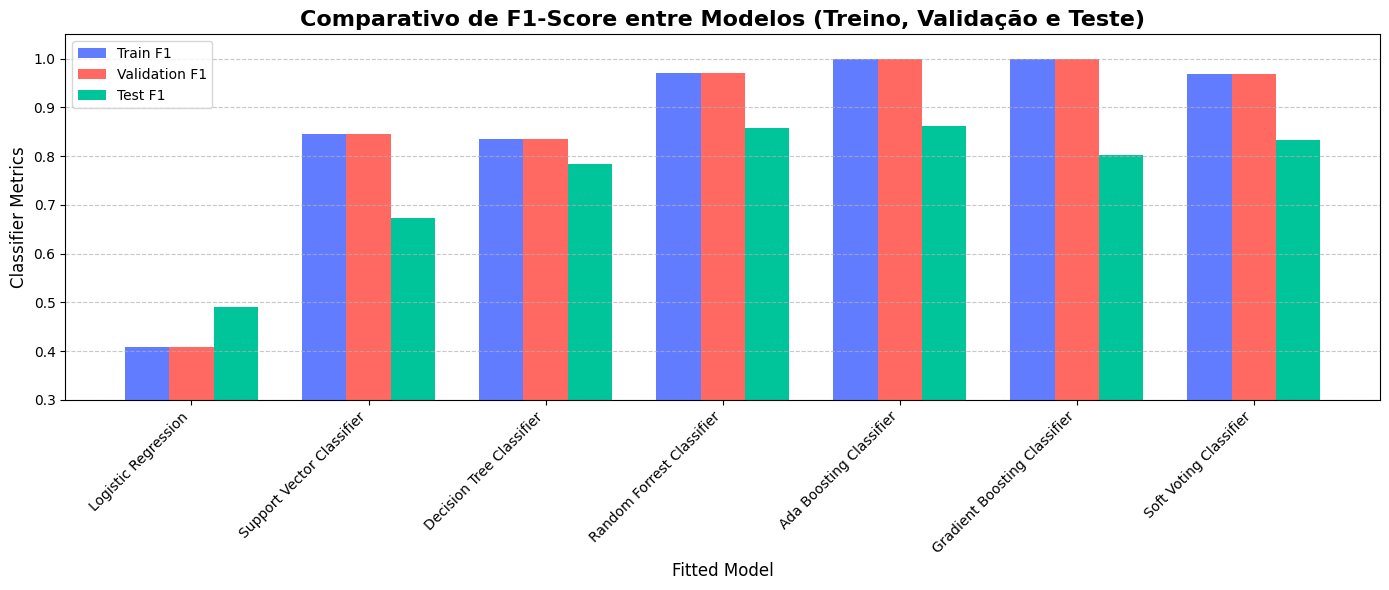

In [ ]:
df = df_experimento[["Model", "Train F1", "Validation F1", "Test F1"]].copy()

bar_width = 0.25
x = np.arange(len(df['Model']))

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width, df['Train F1'], width=bar_width, label='Train F1', color='#627CFF')
plt.bar(x, df['Validation F1'], width=bar_width, label='Validation F1', color='#FF6961')
plt.bar(x + bar_width, df['Test F1'], width=bar_width, label='Test F1', color='#00C49A')

plt.xlabel('Fitted Model', fontsize=12)
plt.ylabel('Classifier Metrics', fontsize=12)
plt.title('Comparativo de F1-Score entre Modelos (Treino, Validação e Teste)', fontsize=16, fontweight='bold')
plt.xticks(ticks=x, labels=df['Model'], rotation=45, ha='right')
plt.ylim(0.3, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

### Legenda: Resultados Finais e Seleção do Modelo


### Análise de Custo vs. Benefício

O critério de seleção será a combinação de duas métricas-chave:
1.  **Benefício (Performance):** O **`Test F1-Score`**, que nos diz quão bem o modelo generaliza para dados novos.
2.  **Custo (Esforço):** O **`Complex Weight`**, que representa o quão "caro" o modelo é em termos de treinamento, manutenção e risco de overfitting.

Vamos comparar os dois melhores candidatos sob essa ótica:

* **Ada Boosting Classifier:**
    * **Benefício (Test F1):** 0.862 (O mais alto)
    * **Custo (Complexidade):** 5 (Alto)
* **Random Forest Classifier:**
    * **Benefício (Test F1):** 0.857 (Quase idêntico ao primeiro)
    * **Custo (Complexidade):** 4 (Menor que o AdaBoost)

---

### Veredito e Justificativa da Escolha

Apesar do `Ada Boosting Classifier` ter o maior F1-Score, a diferença para o `Random Forest Classifier` é mínima (**apenas 0.005**). No entanto, o Random Forest é um modelo **notavelmente menos complexo** (peso 4 vs. 5).



Essa diferença de performance não justifica o aumento na complexidade. O **Random Forest** oferece o melhor retorno sobre o investimento: ele entrega um desempenho de ponta sendo, ao mesmo tempo, mais simples, rápido e potencialmente mais estável que o AdaBoost.

---

### Conclusão Final

O **Random Forest Classifier é selecionado como o modelo final**. Ele representa o ponto ótimo entre **alta performance preditiva** e **eficiência computacional**, tornando-se a escolha mais pragmática e robusta para a implementação deste projeto.

---

## Exportação do Modelo Random Forest

Vamos exportar o modelo **Random Forest** treinado para um arquivo `.joblib` para uso futuro.

In [43]:
import joblib

# Recuperar o modelo Random Forest do experimento
# O Random Forest está na posição 3 do experimento.records
rf_model = experimento.records[3].get("Model Obj")

# Verificar o modelo
print(f"Modelo: {experimento.records[3].get('Model Name')}")
print(f"Tipo: {type(rf_model)}")
print(f"\nParâmetros do modelo:")
print(rf_model.get_params())

Modelo: None
Tipo: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

Parâmetros do modelo:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 7}, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [44]:
# Salvar o modelo em arquivo .joblib
joblib.dump(rf_model, 'random_forest_model.joblib')

print("✅ Modelo Random Forest salvo com sucesso em 'random_forest_model.joblib'")

✅ Modelo Random Forest salvo com sucesso em 'random_forest_model.joblib'


### Exportar modelo completo com métricas (Opcional)

Se você quiser salvar o modelo junto com as métricas de desempenho e hiperparâmetros:

In [45]:
# Salvar modelo com informações adicionais
model_info = {
    'model': experimento.records[3].get("Model Obj"),
    'model_name': experimento.records[3].get("Model Name"),
    'metrics': {
        'test_f1': experimento.records[3].get("Test F1 Score"),
        'test_precision': experimento.records[3].get("Test Precision"),
        'test_recall': experimento.records[3].get("Test Recall"),
        'test_accuracy': experimento.records[3].get("Test Accuracy")
    },
    'hyperparameters': experimento.records[3].get("Model Params")
}

joblib.dump(model_info, 'random_forest_complete.joblib')

print("✅ Modelo completo com métricas salvo em 'random_forest_complete.joblib'")

✅ Modelo completo com métricas salvo em 'random_forest_complete.joblib'


### Como carregar o modelo posteriormente

Para usar o modelo salvo em outro script ou notebook:

In [46]:
# Carregar apenas o modelo
# rf_model_loaded = joblib.load('random_forest_model.joblib')

# Ou carregar o modelo completo com métricas
# model_data = joblib.load('random_forest_complete.joblib')
# rf_model_loaded = model_data['model']
# print(f"Métricas: {model_data['metrics']}")

# Fazer previsões com o modelo carregado
# predictions = rf_model_loaded.predict(X_new)

print("Código de exemplo para carregar o modelo (comentado)")

Código de exemplo para carregar o modelo (comentado)
